In [9]:
# Please keep confidential at this time. While we are going to open source the main contracts, we would like this to remain inside the team until then.

# REQUIREMENTS
# uncomment and run any that you dont have installed
#!pip install sympy
#!pip install numpy
#!pip install plotly
import numpy as np
from sympy import * # For symbolic maths
import plotly.graph_objects as go
import math
import itertools
init_printing()
BASE = 10**18

# in general anything with:
# b_ is borrows followed by platform number (0: dydx, 1:compound, 2:fulcrum)
# c_1 is cash - compound specific
# d_2 is interestPerDay - fulcrum specific
# p_2 is checkpointSupply_ - fulcrum specific
# r_1 is reserves - compound specific
# s_ is supply
# t_1 is total capital
# x,y,z are percentages of total in each platform
# others are various near static terms used various rate functions

b_0, b_1, b_2, c_1, d_2, p_2,r_1, s_0, s_2, t_1, x, y, z, a_0, m_0,a_1, m_1,a_2, m_2,coef_1, coef_7 = symbols('b_0, b_1, b_2, c_1, d_2, p_2,r_1, s_0, s_2, t_1, x, y, z, a_0, m_0,a_1, m_1,a_2, m_2, coef_1, coef_7') # creation of symbols that will be used

<div>
    <h1>Preamble:</h1><br>
    <p>This document is a python representation of what we do on-chain. What is performed on-chain takes into account the limitations of the EVM, this does not. It is purely for demonstrative purposes of what occurs and does it many more times than what occurs on-chain. More on this later </p><br>
<p>You are welcome to analyze the code but I will also provide the mathematical backing and intuition behind it and add comments in functions where it makes sense to. </p><br>
    <p> This implementation only shows the supply side. To do the borrow side, one just needs to use the borrow rate functions instead and minimize. The math is basically identical </p>
  <br>
<h2>Mathematical formulation</h2>
<p> The optimal rate, whether borrow or supply, depends on the underlying formulas for each platform. Since these rate functions vary based on supply amount and borrow amounts, it is not enough to blindly deposit where the rate is highest. We must take into account our capital amount. Additionally, say we have 3 platforms, we assume our current capital amount is known, as well as the rate functions. Our earned Rate is therefore == to:<p> 
$$earnedRate = compound(y)*y + dydx(x)*x + fulcrum(z)*z$$
    
<br><p>Where compound, fulcrum, and dydx take into account the proportion of total capital, call it $platform_{contribution}$. Essentially, all this is saying is that rates vary based on how much money you put in them, and then the earned rate is a function of those rates multiplied by their percentage of total capital.</p>

<br>
<br>
<h2>dYdX</h2>
<a href="https://help.dydx.exchange/en/articles/2924246-how-do-interest-rates-work"> See here for rate info from dydx. </a>
<p>Interest rates on dydx are determined by a supply & demand function. <p>
    
<h2>Compound</h2>
<p><a href="https://etherscan.io/address/0xd928c8ead620bb316d2cefe3caf81dc2dec6ff63#code">See here for compound interest rate calculation via getUtilizationAndAnnualBorrowRate.</a> Supply Rate calculation is in the main <a href="https://etherscan.io/address/0xf5dce57282a584d2746faf1593d3121fcac444dc#code">cToken</a></p>
<h2>Fulcrum</h2>
<p><a href="https://etherscan.io/address/0x87f81f6d710ed717b2981f2bb224935831c5c66a#code"> See here for fulcrum supply interest rate calculation, line 901.</p>

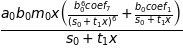

In [10]:
# dYdX Rate functions
#Constant @ time of calculation:
#t_1 = totalCapital
#b_0 = totalBorrows
#s_0 = totalSupply
#a_0 = spreadMultiplier
#m_0 = maxAPR
#coef_n = coefficient n from coefficient array as defined by dYdX interestRateSetter contract
borrowRate_dydx = m_0*(coef_1*(b_0/(s_0 + t_1*x))+coef_7*(b_0/(s_0+t_1*x))**6)
nextSupplyRate_dydx = borrowRate_dydx*a_0*(b_0/(s_0+t_1*x))
dydx_contribution = x*nextSupplyRate_dydx
dydx_contribution 

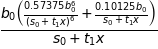

In [11]:
# pluggin in current know values
borrowRate_dydx = .75*(.15*(b_0/(s_0 + t_1*x))+.85*(b_0/(s_0+t_1*x))**6)
nextSupplyRate_dydx = borrowRate_dydx*.9*(b_0/(s_0+t_1*x))
nextSupplyRate_dydx

<p>Plugging in non-varying parameters & distributing b_0/(s_0+t_1*x) & multiplying by total_capital % to dydx:<br><br>$dydx_{contribution} = {x}*\left(\frac{0.57375 b_{0}^{7}}{\left(s_{0} + t_{1} x\right)^{7}} + \frac{0.10125 b_{0}^{2}}{{s_{0} + t_{1} x}^{2}}\right)$</p><br>

<p> So that is our $platform_{contribution}$ for dydx </p>
<p> I am going to speed ahead on these next ones and just jump to finished next contributed capital and spare you the minutia. Happy to discuss the minutia, but feel you can understand from one example</p>

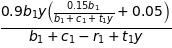

In [12]:
compound_contribution = y*0.9*((.05+.15*(b_1/(b_1+c_1+y*t_1))))*(b_1/(b_1+c_1-r_1+y*t_1))
fulcrum_contribution = z*.9 *d_2 * 1e20 / b_2 * 365 * p_2 / (s_2+z*t_1)  * b_2*1e20/(s_2+z*t_1) /1e20/1e20 # note on all the multiplying/dividing by 1e20, fulcrum adds a lot of these in, but most cancel out
compound_contribution

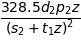

In [13]:
fulcrum_contribution

<p> We now have all the necessary rates and can determine earnedRate given proportion of total_capital x, y, z.</p>
$${earnedRate(x,y,z) = {x}*\left(\frac{0.57375 b_{0}^{7}}{\left(s_{0} + t_{1} x\right)^{7}} + \frac{0.10125 b_{0}^{2}}{{s_{0} + t_{1} x}^{2}}\right) + \frac{0.9 b_{1} y \left(\frac{0.15 b_{1}}{b_{1} + c_{1} + t_{1} y} + 0.05\right)}{b_{1} + c_{1} - r_{1} + t_{1} y} + \frac{328.5 d_{2} p_{2} z}{\left(s_{2} + t_{1} z\right)^{2}}}$$<br>
<h1> Optimization </h1>
<p> while it would be great to be able to <a href=https://en.wikipedia.org/wiki/Lagrange_multiplier> use lagrange mutlipliers </a> we don't satisfy all the necessary KKT conditions. This would have theoretically given us an analytically perfect solution. </p><br><p> Instead, we have a constrained optimization problem that is not analytically solvable and is performed in a highly resource constrained environment. In fact we have a nonlinear <a href="https://en.wikipedia.org/wiki/Convex_optimization">convex optimization</a> problem that we can solve with Lagrangian relaxation. The method we use is called <a href="https://en.wikipedia.org/wiki/Subgradient_method#Subgradient-projection_&_bundle_methods">Subgradient Projection</a>. This method minimizes storage and the complexity of the operations we have to perform and maintains similar accuracy to a naive brute force method generally down to the 1/1000 of a percent of optimal, can be more accurate at the cost of more computation/gas. The gist of this method, is that is is gradient descent, that is projected down into the constraint set. Gradient descent is a method of finding minimums of a function by taking the derivative at each step, then adjusting your next guess by adding/subtracting the gradient*learningRate. In a constrained problem, this new point wont necessarily be in the constraint set. So after computing the new point, you find the point closest to the point on the constraint set. This is basically projecting a point onto a plane in our problem (or hyperplane if $\mathbb{R}^{4+}$, in the case where we have 4+ integrated platforms). To be honest, the hyperlinked wikipedia articles explain everything pretty well.</p><br><p>I think the best way for you to get a grasp of this is by seeing some visuals</p><br><br>

To make it clear, if I haven't already, we are trying to solve for max earnedRate(x,y,z) where x+y+z = 1, where each variable represents a fraction of the total capital. Therefore we need to project each optimization interation of our earnedRate function into our constraint plane ${x + y + z = 1}$. With just 10 iterations, we achieve very good results. See Graph 2. Graph 1 answers the question: What does the entire search space look when:<br> 1) calculate gradient & graph with cones in direction of gradient,<br> 2) graph the unprojected point,<br> 3) project the unprojected point into the constraint plane<br><br>

Quick note: since we are trying to maximize, we actually add, not subtract the gradient

<h2> Graph 1</h2>

In [ ]:
num=100 # percision of search space; i.e. 100 = 1% iterations, 1000 = 0.1% iterations. 100 is performant. breaks down performance wise around 300
b_0, b_1, b_2, c_1, d_2, p,r_1, s_0, s_2, t_1, x, y, z, lam = symbols('b_0, b_1, b_2, c_1, d, p,r_1, s_0, s_2, t_1, x, y, z, lam ')
BASE = 10**18

## VARIABLES
# We are dividing by BASE in all of these to scale down to easy-to-reason about allocations of 0% to 100% allocation of total capital
# Each of these can be changed as you want to explore different variations
# If t_1 is very high you run into vanishing gradient issues, but thats because at super high capital amounts, it doesnt matter
# as much where you put the capital because rates will tend toward 0 because we don't vary the borrowing proportionally.

t1 = 1e24 / BASE # totalCapital 1e24/BASE == 1,000,000 
# While we are using a low capital amount, this is just to have an easily understandable showcase example. Increase capital amounts here to test larger sums, but
# be aware of the above comment regarding vanishing gradients and in this model not changing borrow side proportionately

# most of the below numbers are designed to showcase an interesting but understandable example. Feel free to tweak as you see fit.

## dYdX
b0 = 4002380 * 1e18 / BASE + 1000000 # dydx Borrows
s0 = 5524878 * 1e18 / BASE # dydx supply

## COMPOUND
b1 = 27532955861993220022655277 / BASE # compound borrows
c1 = 7298988660469598230692126 / BASE # compound Cash
s1 = 169503834586461108 / BASE # compound supply, ignore, different than other supplies.
r1 = 47118072262466981682308 / BASE # compound reserves



### FULCRUM
s2 = 303006293339075778981663  /BASE # fulcrum supply
b2 = 231954058219810962239103 /BASE # fulcrum borrow
p2 = 303002778949861886847838  /BASE # fulcrum supply_checkpoint
d2 = 97763362658256982693  /BASE # fulcrum interestPerDay

# 1xN Matrix addition, with rounding
def matPlus(a,b):
    c = []
    for i in range(len(a)):
        c.append(round(a[i]+b[i], 3))
    return c

# 1xN Matrix subtraction, with rounding
def matMinus(a,b):
    c = []
    for i in range(len(a)):
        c.append(round(a[i]-b[i], 3))
    return c

# 1xN Matrix scalar multiplication
def matMulScalar(c,a):
    b = []
    for i in range(len(a)):
        b.append(a[i]*c)
    return b

# 1xN Matrix dot product
def dot(a,b):
    c = 0
    for i in range(3):
        c += a[i]*b[i]
    return c

# point to line projection for when projection is still not in the plane
def pointLineProj(a,b,p):
    ap = matMinus(p,a)
    ab = matMinus(b,a)
    return matPlus(a, matMulScalar((dot(ap,ab) / dot(ab,ab)),ab))



# Just a color map, ignore
pl_curl=[[0.0, 'rgb(20, 29, 67)'],# curl is a cmocean colormap 
         [0.05, 'rgb(25, 52, 80)'],
         [0.1, 'rgb(28, 76, 96)'],
         [0.15, 'rgb(23, 100, 110)'],
         [0.2, 'rgb(16, 125, 121)'],
         [0.25, 'rgb(44, 148, 127)'],
         [0.3, 'rgb(92, 166, 133)'],
         [0.35, 'rgb(140, 184, 150)'],
         [0.4, 'rgb(182, 202, 175)'],
         [0.45, 'rgb(220, 223, 208)'],
         [0.5, 'rgb(253, 245, 243)'],
         [0.55, 'rgb(240, 215, 203)'],
         [0.6, 'rgb(230, 183, 162)'],
         [0.65, 'rgb(221, 150, 127)'],
         [0.7, 'rgb(211, 118, 105)'],
         [0.75, 'rgb(194, 88, 96)'],
         [0.8, 'rgb(174, 63, 95)'],
         [0.85, 'rgb(147, 41, 96)'],
         [0.9, 'rgb(116, 25, 93)'],
         [0.95, 'rgb(82, 18, 77)'],
         [1.0, 'rgb(51, 13, 53)']]
ns = []
for i in pl_curl:
    ns.append(i[0])
ns = ns[::-1]
for i in range(len(pl_curl)):
    pl_curl[i][0] = ns[i]
pl_curl = pl_curl[::-1]   



combos = []
# this function creates the search space combinations such that x+y+z = 1. Not used in optimization, just for visualization purposes
def partitions(n, k):
    for c in itertools.combinations(range(n+k-1), k-1):
        yield [b-a-1 for a, b in zip((-1,)+c, c+(n+k-1,))]

for par in partitions(num, 3):
    combos.append(par)
    
returnMap = {}   




L = 2 # Learning rate

def calcAPR(x_,y_,z_):
        d = x*0.9*0.75*(0.15*(b0/(s0+x*t1))+0.85*(b0/(s0+x*t1))**6 )*(b0/(s0+x*t1)) #dydx contribution function
        c = y*0.9*((.05+.15*(b1/(b1+c1+y*t1))))*(b1/(b1+c1-r1+y*t1)) # compound contribution function
        f = z*.9 *d2 * 1e20 / b2 * 365 * p2 / (s2+z*t1)  * b2*1e20/(s2+z*t1) /1e20/1e20 # fulcrum contribution function
        dxv = d.subs([(x,x_)]) # substitute in the given x percentage to contribution function
        dyv = c.subs([(y,y_)])
        dzv = f.subs([(z,z_)])
        xV = diff(d,x).subs([(x,x_)]) # take the derivative and evaluate percentage
        yV = diff(c,y).subs([(y,y_)])
        zV = diff(f,z).subs([(z,z_)])
        
        #gradient descent
        nX = x_+L*xV
        nY = y_+L*yV
        nZ = z_+L*zV
        
        # distance from constraint plane given that the normal of the plane is 1, therefore unit normal vector is sqrt(3)/3
        xdist = (nX-x_)*(math.sqrt(3)/3)
        ydist = (nY-y_)*(math.sqrt(3)/3)
        zdist = (nZ-z_)*(math.sqrt(3)/3)

        # total euclidean distance
        dist = xdist + ydist + zdist
        
        # Distance to constraint plane
        vn = dist*math.sqrt(3)/3
        
        # Projection down onto the plane
        projX = nX - vn
        projY = nY - vn
        projZ = nZ - vn
        
        
        # Edge case handling where projects onto plane but is still outside constraint space
        # instead of doing projection onto plane, performs projection onto line along f(x,y), f(x,z), or f(y,z)
        # i.e. projection was -.1, 1.1, 0 -> needs to be flattened further into constraint boundary line
        if projZ < 0:
            #project onto boundary line
            projV = pointLineProj([1,0,0],[0,1,0], [nX,nY,nZ])
            for i in range(3):
                if projV[i] < 0:
                    projV[i] = 0
                if projV[i] > 1:
                    projV[i] = 1
            projX = projV[0]
            projY = projV[1]
            projZ = projV[2]

        if projX < 0:
            projV = pointLineProj([0,1,0],[0,0,1], [projX,projY,projZ])
            for i in range(3):
                if projV[i] < 0:
                    projV[i] = 0
                if projV[i] > 1:
                    projV[i] = 1
            projX = projV[0]
            projY = projV[1]
            projZ = projV[2]
                
        if projY < 0:
            projV = pointLineProj([1,0,0],[0,0,1], [projX,projY,projZ])
            for i in range(3):
                if projV[i] < 0:
                    projV[i] = 0
                if projV[i] > 1:
                    projV[i] = 1
            projX = projV[0]
            projY = projV[1]
            projZ = projV[2]
            
        # APR, gradX, gradY, gradZ, offConstraintPlaneX, offConstraintPlaneY, offConstraintPlaneZ, projectedOnConstraintPlaneX, projectedOnConstraintPlaneY, projectedOnConstraintPlaneZ
        return float(dxv + dyv + dzv), float(xV), float(yV), float(zV), float(nX), float(nY), float(nZ), float(projX), float(projY), float(projZ)


xs = []
ys = []
zs = []
u = []
v = []
w = []
x2s = []
y2s = []
z2s = []
cs = []


# data processing for visualization
for i in range(len(combos)):
    for j in range(len(combos[i])):
        combos[i][j] = combos[i][j] / num
    APR, ui, vi, wi,x2, y2, z2, projX, projY,projZ  = calcAPR(combos[i][0],combos[i][1],combos[i][2])    
    u.append(ui)
    v.append(vi)
    w.append(wi)
    x2s.append(projX)
    y2s.append(projY)
    z2s.append(projZ)
    x2s.append(x2)
    y2s.append(y2)
    z2s.append(z2)
    cs.append(APR)
    cs.append(APR)
    returnMap[i] = {"APR":APR, "x":combos[i][0], "y":combos[i][1], "z":combos[i][2]}
    
for i in returnMap:
    xs.append(returnMap[i]["x"])
    ys.append(returnMap[i]["y"])
    zs.append(returnMap[i]["z"])
#     cs.append(returnMap[i]["APR"])
dots = go.Scatter3d(
            x=x2s,
            y=y2s,
            z=z2s,
            marker=dict(size=4,color=cs, colorscale=pl_curl),
            mode="markers"
            )

cones = dict(type='cone',
              x=xs,
              y=ys, 
              z=zs, 
              u=u, 
              v=v, 
              w=w, 
              sizemode='scaled',
              cauto=False,
              sizeref=2,
#               showscale=True,
#               colorscale=pl_curl, 
#               colorbar=dict(thickness=20, ticklen=4, len=0.75), 
              anchor='tail'
          )


fig = go.Figure(data=[cones,dots])
fig.update_layout(
    width=1200, #adjust this if you are not using a jupyter-themes notebook w/ cell-width set to 100% of window
    height=800,
    paper_bgcolor="black",
    scene = dict(
                    xaxis = dict(
                         backgroundcolor="black",
                         gridcolor="rgb(128,128,128)",
                         showbackground=True,
                         zerolinecolor="rgb(128,128,128)",),
                    yaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)"),
                    zaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)",),)
)
fig.show()   

<p>Quick explanation: the furthest back triangle (filled with purple to yellow cones) are the calculated gradients at search_space_stepsize = 1%. The green/white/magenta triangle consists of points that result from the gradient*learningRate + current_(x,y,z). As you can see, these are off the constraint plane. Therefore we need to find the closest point on the constraint plane via projection. The green/white/magenta on the triangle are the projected points.</p><br><br>


<h2>Graph 2 </h2>
<p> for this graph, we want to evaluate how well we are optimizing. Based on the above graph, which is a brute force search of the entire space, we want to take a subset. This next one chooses 50 random start points and shows how they optimize at each iteration. Note: each one of these 50 are sufficient. 50 are chosen to showcase convergence across the search space (i.e. given the worst possible allocation, how well can we do?). In reality, only one of these lines happens and needs to be calculated. </p>

In [ ]:
cs =[]
data = []
num = 100
combos = []
def partitions(n, k):
    for c in itertools.combinations(range(n+k-1), k-1):
        yield [b-a-1 for a, b in zip((-1,)+c, c+(n+k-1,))]

for par in partitions(num, 3):
    combos.append(par)
    

cmain = []
xmain = []
ymain = []
zmain = []
for j in range(50):
    selector = np.random.randint(1,len(combos), size=1)[0]
    x_ = combos[selector][0]/100
    y_ = combos[selector][1]/100
    z_ = combos[selector][2]/100
    x2s = [x_]
    y2s = [y_]
    z2s = [z_]
    cs = []
    for i in range(10):
        APR, ui, vi, wi,x2, y2, z2, projX, projY,projZ = calcAPR(x_,y_,z_)
        x2s.append(projX)
        y2s.append(projY)
        z2s.append(projZ)
        cs.append(APR)
        x_ = projX
        y_ = projY
        z_ = projZ
    xmain += x2s
    ymain += y2s
    zmain += z2s
    cmain += cs
    dots = go.Scatter3d(
                x=x2s,
                y=y2s,
                z=z2s,
                marker=dict(size=5,color=cs,colorscale=pl_curl),
                line=dict(color=[
          "rgb(166,206,227)",
          "rgb(31,120,180)",
          "rgb(31,120,180)",
          "rgb(178,223,138)",
          "rgb(51,160,44)",
          "rgb(51,160,44)",
          "rgb(251,154,153)",
          "rgb(227,26,28)",
          "rgb(255,127,0)",
          "rgb(106,61,154)",
          "rgb(106,61,154)"
        ],width=4)
    #             mode="markers"
                )  
    data.append(dots)
        
cones = dict(type='cone',
              x=xs,
              y=ys, 
              z=zs, 
              u=u, 
              v=v, 
              w=w, 
              sizemode='scaled',
              cauto=False,
              sizeref=1.2,
#               showscale=True,
#               colorscale=pl_curl, 
#               colorbar=dict(thickness=20, ticklen=4, len=0.75), 
              anchor='tail'
          )
data.append(cones)
fig = go.Figure(data=data)
fig.update_layout(
    width=1600,
    height=1400,
    paper_bgcolor="black",
    scene = dict(
                    xaxis = dict(
                         backgroundcolor="black",
                         gridcolor="rgb(128,128,128)",
                         showbackground=True,
                         zerolinecolor="rgb(128,128,128)",),
                    yaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)"),
                    zaxis = dict(
                        backgroundcolor="black",
                        gridcolor="rgb(128,128,128)",
                        showbackground=True,
                        zerolinecolor="rgb(128,128,128)",),)
)
fig.show()  

Reminder: This next one chooses 50 random start points and shows how they optimize at each iteration. Note: any one of these 50 are sufficient. 50 are chosen to showcase convergence across the search space (i.e. given the worst possible allocation, how well can we do?). In reality, only one of these lines needs to be calculated.<br><br>

Now lets evaluate how we did. cmain variable holds all APRs, but we just want the last element in each set essentially (the final optimized point). Remember, in reality, we only ran 10 calculations, i.e. one of the lines above.

In [ ]:
print(min(cmain[9::10]))
print(max(cmain[9::10]))

There is clearly very high convergence after just 10 iterations regardless of where you start on the constraint plane. But how does it fair vs a naive brute force search?

In [ ]:
# Note @ 1000 for this variable, the number of combos is 501501, so this can run pretty slow. I recommend NOT running this one for yourself, but you're welcome to it.
combos = []
num = 1000 # Down to one 10th of percent
def partitions(n, k):
    for c in itertools.combinations(range(n+k-1), k-1):
        yield [b-a-1 for a, b in zip((-1,)+c, c+(n+k-1,))]

for par in partitions(num, 3):
    combos.append(par)
    
returns = []  
for i in range(len(combos)):
    for j in range(len(combos[i])):
        combos[i][j] = combos[i][j] / num
    d = x*0.9*0.75*(0.15*(b0/(s0+x*t1))+0.85*(b0/(s0+x*t1))**6 )*(b0/(s0+x*t1)) #dydx contribution function
    c = y*0.9*((.05+.15*(b1/(b1+c1+y*t1))))*(b1/(b1+c1-r1+y*t1)) # compound contribution function
    f = z*.9 *d2 * 1e20 / b2 * 365 * p2 / (s2+z*t1)  * b2*1e20/(s2+z*t1) /1e20/1e20 # fulcrum contribution function
    dxv = d.subs([(x,x_)]) # substitute in the given x percentage to contribution function
    dyv = c.subs([(y,y_)])
    dzv = f.subs([(z,z_)])
    returns.append(float(dxv)+float(dyv)+float(dzv))
    
max(returns)    

For a naive brute force search that takes awhile, the results aren't very impressive compared to subgradient. The worst optimization via subgradient projection is .02% (in my test, if you rerun the above it will be different) worse than brute force search and the best optimization is fractionally better than the brute force. <br><br>

All this is to say, we have a low step count optimization technique on a relatively hard problem. Feel free to ask me questions, ask me to go into the math a bit more, etc. Feel free to tinker with values